In [1]:
import pandas as pd
df=pd.read_csv("/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv")
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


# import libraries and data loading

In [2]:
# =============================================================================
# PART 1: IMPORT LIBRARIES AND DATA LOADING
# =============================================================================

# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load the dataset
# For Kaggle: Update path to your dataset location
df = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv')

print("="*80)
print("DATASET LOADED SUCCESSFULLY")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"Total Records: {df.shape[0]:,}")
print(f"Total Features: {df.shape[1]}")
print("\nFirst 5 rows:")
print(df.head())


DATASET LOADED SUCCESSFULLY

Dataset Shape: (253680, 22)
Total Records: 253,680
Total Features: 22

First 5 rows:
   Diabetes_012  HighBP  HighChol  CholCheck    BMI  Smoker  Stroke  \
0         0.000   1.000     1.000      1.000 40.000   1.000   0.000   
1         0.000   0.000     0.000      0.000 25.000   1.000   0.000   
2         0.000   1.000     1.000      1.000 28.000   0.000   0.000   
3         0.000   1.000     0.000      1.000 27.000   0.000   0.000   
4         0.000   1.000     1.000      1.000 24.000   0.000   0.000   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                 0.000         0.000   0.000    1.000              0.000   
1                 0.000         1.000   0.000    0.000              0.000   
2                 0.000         0.000   1.000    0.000              0.000   
3                 0.000         1.000   1.000    1.000              0.000   
4                 0.000         1.000   1.000    1.000              0.000 

# data cleaning and pre-processing

In [3]:
# =============================================================================
# PART 2: DATA CLEANING AND PREPROCESSING
# =============================================================================

print("\n" + "="*80)
print("DATA CLEANING AND PREPROCESSING")
print("="*80)

# 2.1 Check data types
print("\n--- Data Types ---")
print(df.dtypes)
print(f"\nInfo:")
df.info()

# 2.2 Check for missing values
print("\n--- Missing Values Analysis ---")
missing_vals = df.isnull().sum()
missing_percent = (missing_vals / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_vals.index,
    'Missing_Count': missing_vals.values,
    'Missing_Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_df)

# 2.3 Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\n--- Duplicate Rows: {duplicates} ---")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows")

# 2.4 Create a copy for cleaning
df_clean = df.copy()

# 2.5 Handle zero values in certain columns (common in diabetes datasets)
# Columns where 0 doesn't make medical sense
zero_cols = ['BMI']  # Add other columns like Glucose, BloodPressure if present in your data

for col in zero_cols:
    if col in df_clean.columns:
        zero_count = (df_clean[col] == 0).sum()
        print(f"\n{col}: {zero_count} zero values found")
        
        # Replace zeros with median (more robust than mean for outliers)
        median_val = df_clean[df_clean[col] != 0][col].median()
        df_clean[col] = df_clean[col].replace(0, median_val)
        print(f"Replaced zeros with median: {median_val:.2f}")

# 2.6 Handle missing values
# Strategy: Use median for numerical, mode for categorical
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype in ['int64', 'float64']:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
        else:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

print("\n--- Data Cleaning Complete ---")
print(f"Final Shape: {df_clean.shape}")
print(f"Remaining Missing Values: {df_clean.isnull().sum().sum()}")

# 2.7 Create categorical mappings for better interpretation
# Based on your dataset structure
category_mappings = {
    'Sex': {0: 'Female', 1: 'Male'},
    'HighBP': {0: 'No', 1: 'Yes'},
    'HighChol': {0: 'No', 1: 'Yes'},
    'Smoker': {0: 'No', 1: 'Yes'},
    'Stroke': {0: 'No', 1: 'Yes'},
    'HeartDiseaseorAttack': {0: 'No', 1: 'Yes'},
    'PhysActivity': {0: 'No', 1: 'Yes'},
    'Fruits': {0: 'No', 1: 'Yes'},
    'Veggies': {0: 'No', 1: 'Yes'},
    'HvyAlcoholConsump': {0: 'No', 1: 'Yes'},
    'AnyHealthcare': {0: 'No', 1: 'Yes'},
    'NoDocbcCost': {0: 'No', 1: 'Yes'},
    'DiffWalk': {0: 'No', 1: 'Yes'},
    'Diabetes_012': {0: 'No Diabetes', 1: 'Pre-diabetes', 2: 'Diabetes'}
}

# Create labeled versions for visualization
df_labeled = df_clean.copy()
for col, mapping in category_mappings.items():
    if col in df_labeled.columns:
        df_labeled[f'{col}_Label'] = df_labeled[col].map(mapping)

# 2.8 Normalize continuous variables for analysis
scaler = StandardScaler()
continuous_cols = ['BMI', 'MentHlth', 'PhysHlth']  # Add other continuous columns

df_normalized = df_clean.copy()
if all(col in df_normalized.columns for col in continuous_cols):
    df_normalized[continuous_cols] = scaler.fit_transform(df_normalized[continuous_cols])
    print("\n--- Continuous variables normalized ---")

print("\n" + "="*80)



DATA CLEANING AND PREPROCESSING

--- Data Types ---
Diabetes_012            float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Di

# Exploratory Data Analysis


EXPLORATORY DATA ANALYSIS

--- Statistical Summary ---
                          count   mean   std    min    25%    50%    75%  \
Diabetes_012         229781.000  0.326 0.725  0.000  0.000  0.000  0.000   
HighBP               229781.000  0.454 0.498  0.000  0.000  0.000  1.000   
HighChol             229781.000  0.442 0.497  0.000  0.000  0.000  1.000   
CholCheck            229781.000  0.960 0.197  0.000  1.000  1.000  1.000   
BMI                  229781.000 28.686 6.786 12.000 24.000 27.000 32.000   
Smoker               229781.000  0.466 0.499  0.000  0.000  0.000  1.000   
Stroke               229781.000  0.045 0.207  0.000  0.000  0.000  0.000   
HeartDiseaseorAttack 229781.000  0.103 0.304  0.000  0.000  0.000  0.000   
PhysActivity         229781.000  0.733 0.442  0.000  0.000  1.000  1.000   
Fruits               229781.000  0.613 0.487  0.000  0.000  1.000  1.000   
Veggies              229781.000  0.795 0.404  0.000  1.000  1.000  1.000   
HvyAlcoholConsump    229781.000 

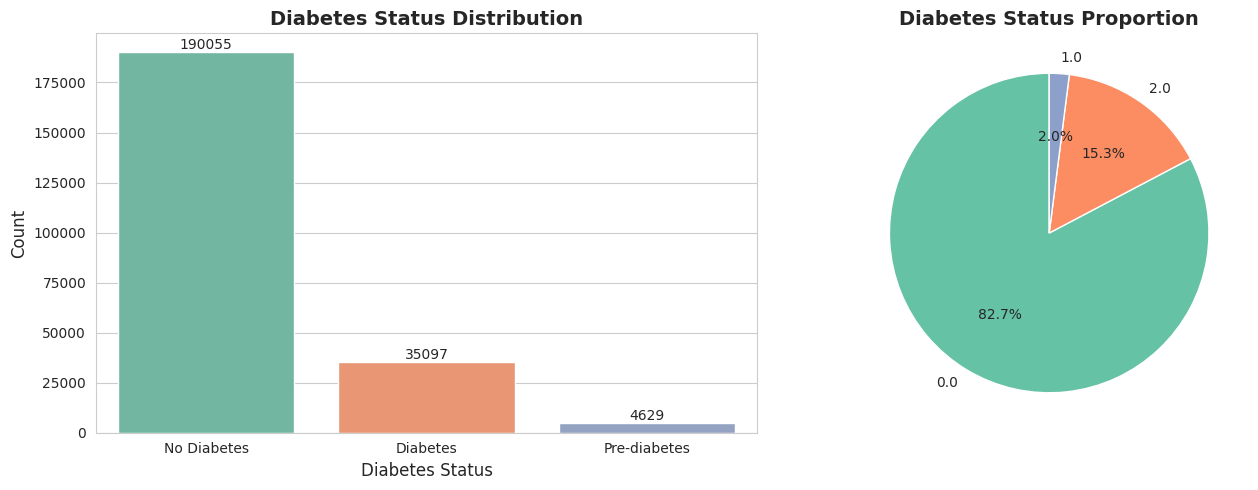


--- Age Distribution ---


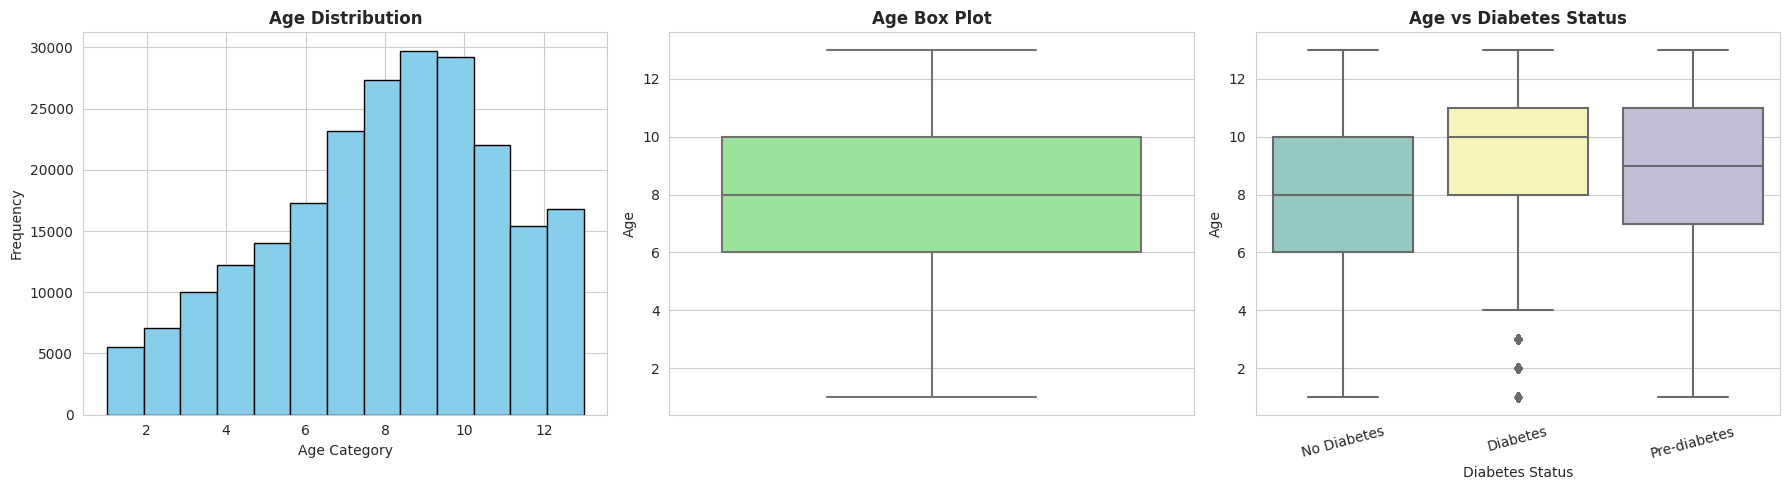


--- BMI Distribution ---
Mean BMI: 28.69
Median BMI: 27.00
Std Dev: 6.79


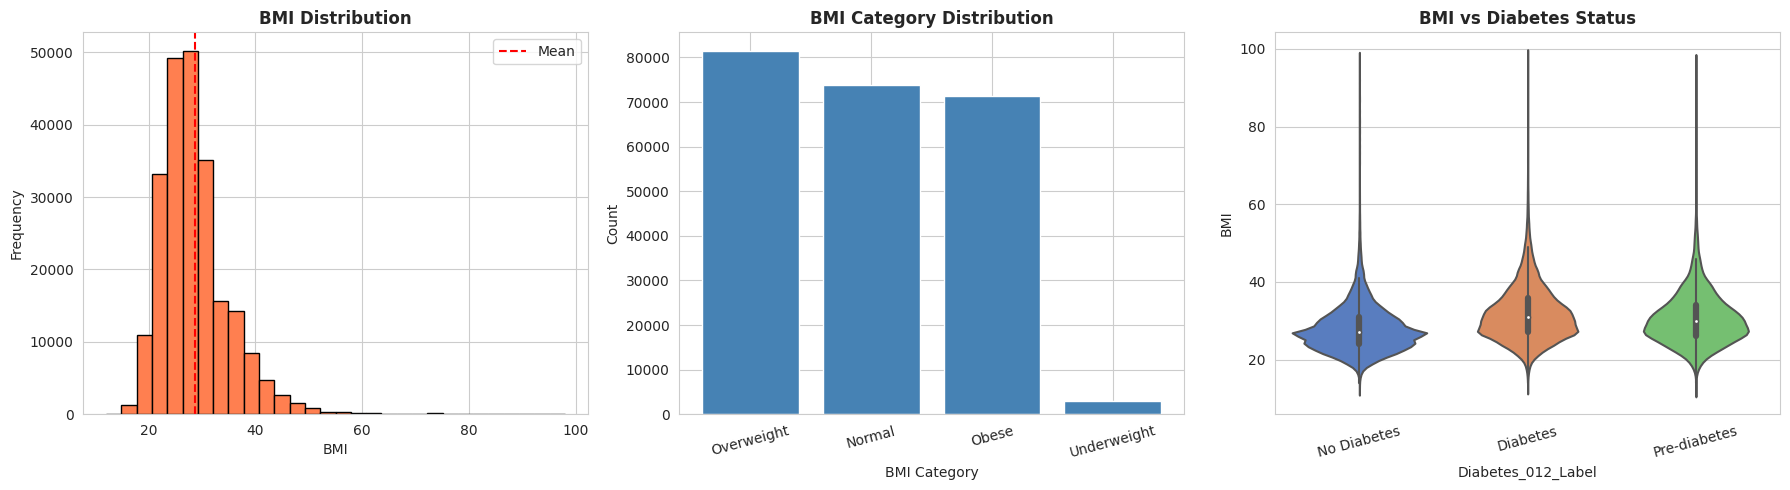


--- Health Factors Distribution ---


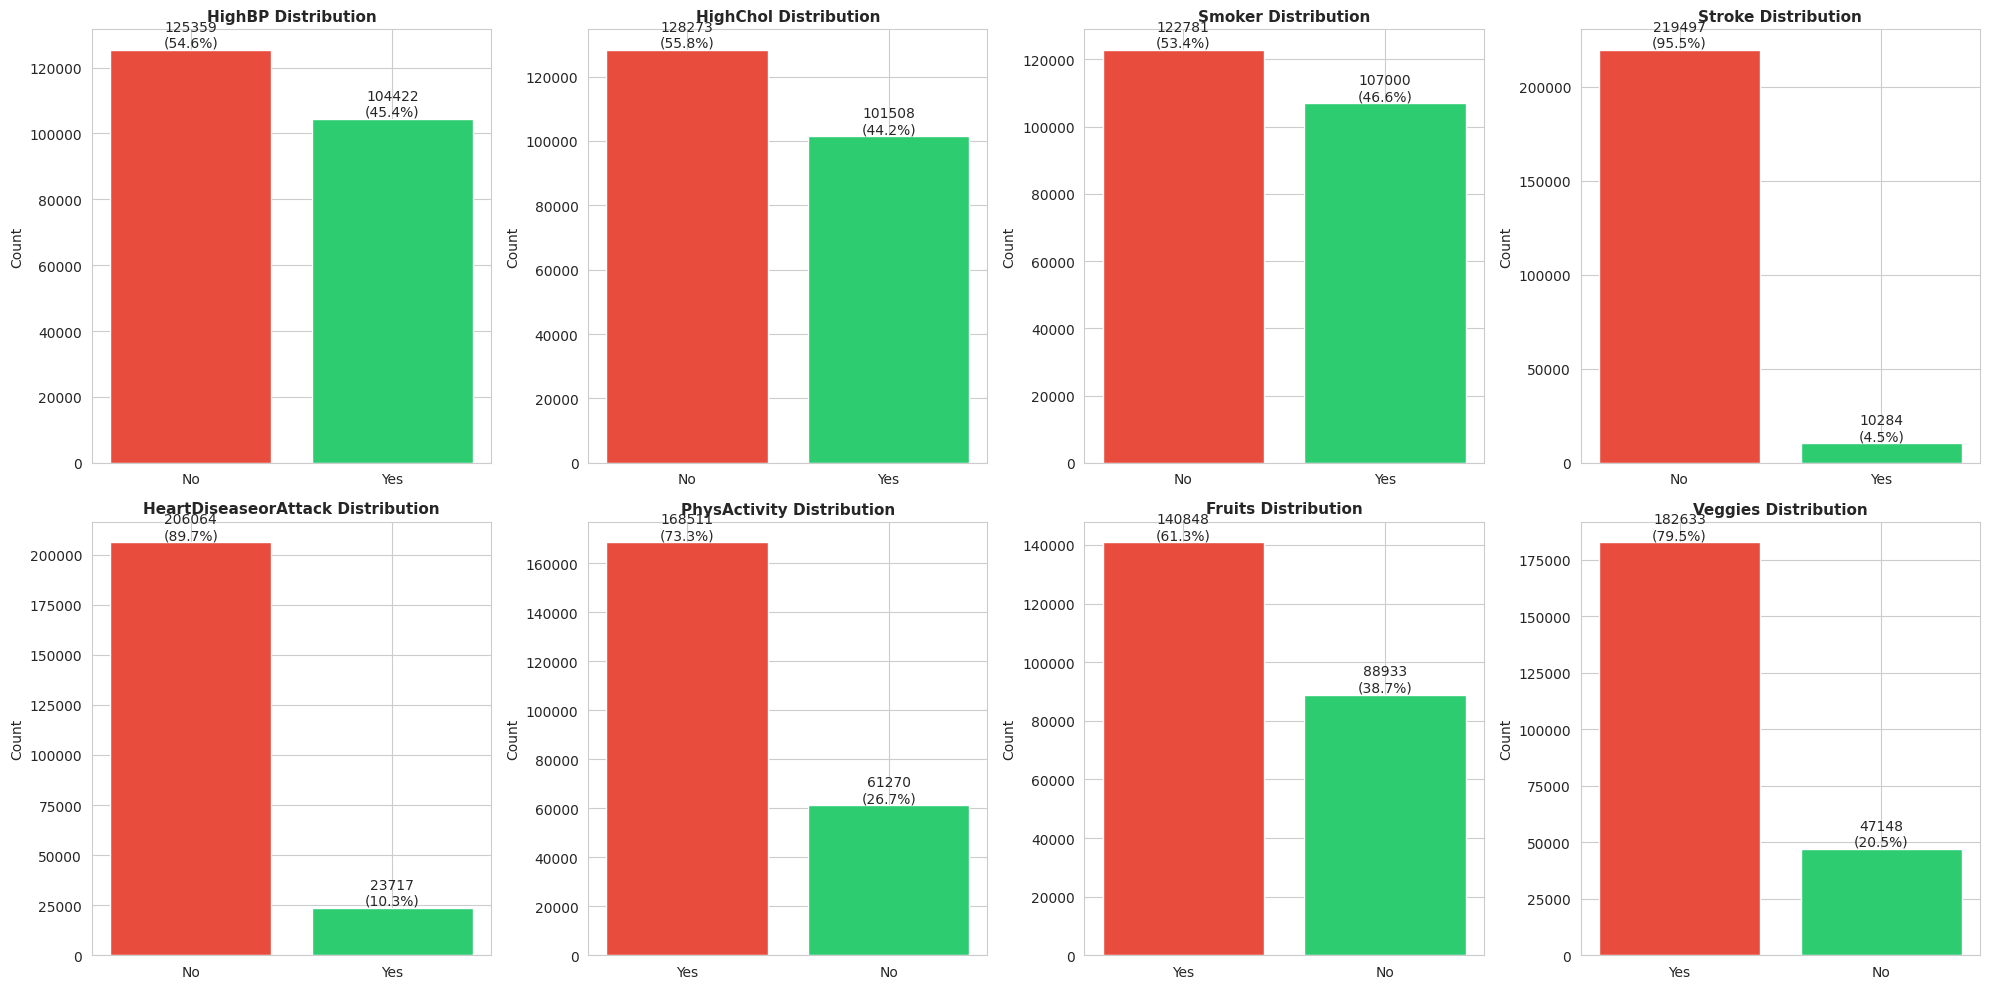


--- Correlation Matrix ---


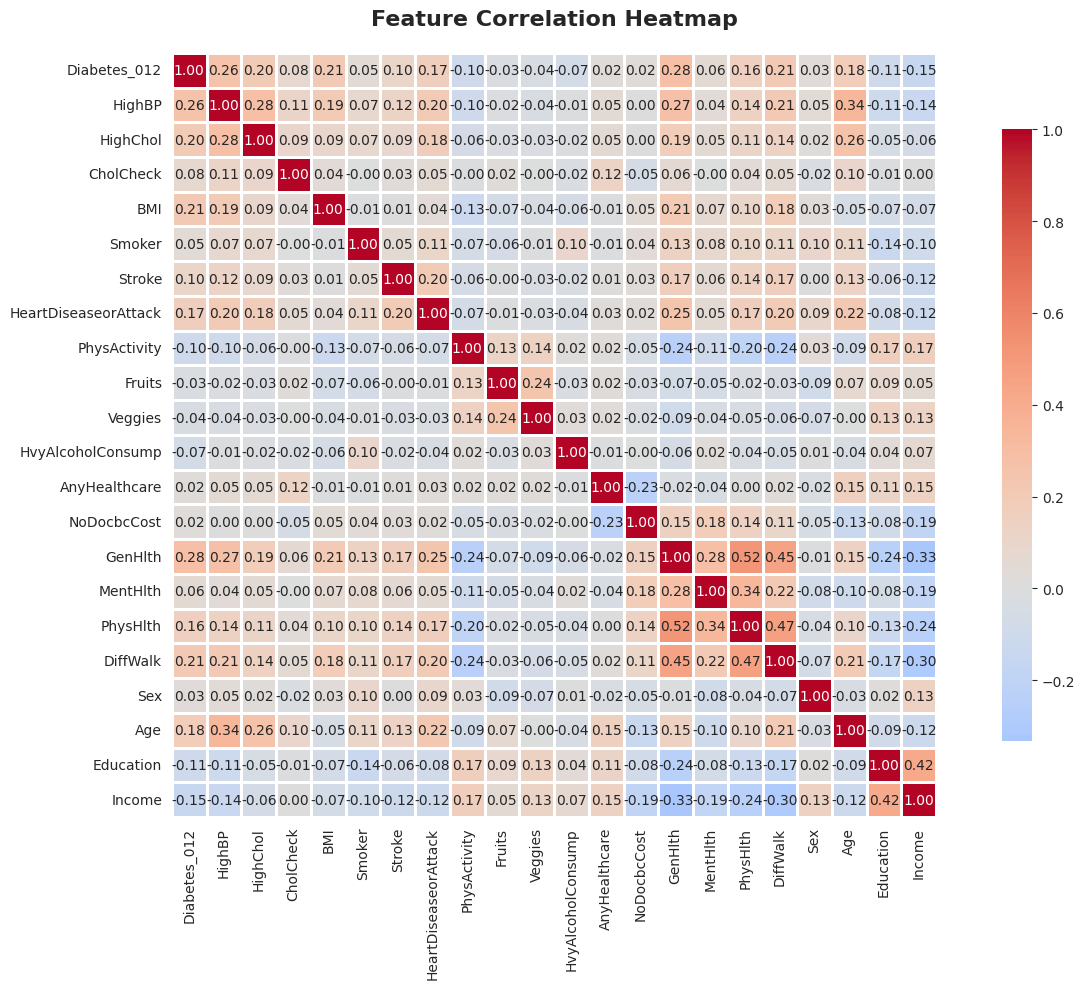


Top features correlated with Diabetes:
GenHlth                0.285
HighBP                 0.262
BMI                    0.212
DiffWalk               0.211
HighChol               0.203
Age                    0.185
HeartDiseaseorAttack   0.171
PhysHlth               0.160
Stroke                 0.100
CholCheck              0.076
Name: Diabetes_012, dtype: float64



In [4]:
# =============================================================================
# PART 3: EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# 3.1 Statistical Summary
print("\n--- Statistical Summary ---")
print(df_clean.describe().T)

# 3.2 Target Variable Distribution
if 'Diabetes_012' in df_clean.columns:
    print("\n--- Diabetes Distribution ---")
    diabetes_dist = df_clean['Diabetes_012'].value_counts()
    diabetes_pct = df_clean['Diabetes_012'].value_counts(normalize=True) * 100
    
    print(pd.DataFrame({
        'Count': diabetes_dist,
        'Percentage': diabetes_pct
    }))
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count plot
    sns.countplot(data=df_labeled, x='Diabetes_012_Label', palette='Set2', ax=ax1)
    ax1.set_title('Diabetes Status Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Diabetes Status', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    
    # Add value labels
    for container in ax1.containers:
        ax1.bar_label(container)
    
    # Pie chart
    colors = ['#66c2a5', '#fc8d62', '#8da0cb']
    ax2.pie(diabetes_dist.values, labels=diabetes_dist.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    ax2.set_title('Diabetes Status Proportion', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# 3.3 Age Distribution Analysis
if 'Age' in df_clean.columns:
    print("\n--- Age Distribution ---")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Histogram
    axes[0].hist(df_clean['Age'], bins=13, color='skyblue', edgecolor='black')
    axes[0].set_title('Age Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Age Category')
    axes[0].set_ylabel('Frequency')
    
    # Box plot
    sns.boxplot(data=df_clean, y='Age', color='lightgreen', ax=axes[1])
    axes[1].set_title('Age Box Plot', fontsize=12, fontweight='bold')
    
    # Age vs Diabetes
    if 'Diabetes_012' in df_clean.columns:
        sns.boxplot(data=df_labeled, x='Diabetes_012_Label', y='Age', 
                    palette='Set3', ax=axes[2])
        axes[2].set_title('Age vs Diabetes Status', fontsize=12, fontweight='bold')
        axes[2].set_xlabel('Diabetes Status')
        axes[2].tick_params(axis='x', rotation=15)
    
    plt.tight_layout()
    plt.show()

# 3.4 BMI Analysis
if 'BMI' in df_clean.columns:
    print("\n--- BMI Distribution ---")
    print(f"Mean BMI: {df_clean['BMI'].mean():.2f}")
    print(f"Median BMI: {df_clean['BMI'].median():.2f}")
    print(f"Std Dev: {df_clean['BMI'].std():.2f}")
    
    # Create BMI categories
    df_clean['BMI_Category'] = pd.cut(df_clean['BMI'], 
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Distribution
    axes[0].hist(df_clean['BMI'], bins=30, color='coral', edgecolor='black')
    axes[0].set_title('BMI Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('BMI')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(df_clean['BMI'].mean(), color='red', linestyle='--', label='Mean')
    axes[0].legend()
    
    # BMI Category counts
    bmi_cat_counts = df_clean['BMI_Category'].value_counts()
    axes[1].bar(bmi_cat_counts.index, bmi_cat_counts.values, color='steelblue')
    axes[1].set_title('BMI Category Distribution', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('BMI Category')
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=15)
    
    # BMI vs Diabetes
    if 'Diabetes_012' in df_clean.columns:
        sns.violinplot(data=df_labeled, x='Diabetes_012_Label', y='BMI', 
                       palette='muted', ax=axes[2])
        axes[2].set_title('BMI vs Diabetes Status', fontsize=12, fontweight='bold')
        axes[2].tick_params(axis='x', rotation=15)
    
    plt.tight_layout()
    plt.show()

# 3.5 Health Factors Analysis
health_factors = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
                  'PhysActivity', 'Fruits', 'Veggies']
available_factors = [col for col in health_factors if col in df_clean.columns]

if available_factors:
    print("\n--- Health Factors Distribution ---")
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for idx, factor in enumerate(available_factors):
        if f'{factor}_Label' in df_labeled.columns:
            factor_counts = df_labeled[f'{factor}_Label'].value_counts()
            axes[idx].bar(factor_counts.index, factor_counts.values, 
                         color=['#e74c3c', '#2ecc71'])
            axes[idx].set_title(f'{factor} Distribution', fontsize=11, fontweight='bold')
            axes[idx].set_ylabel('Count')
            
            # Add percentage labels
            total = factor_counts.sum()
            for i, v in enumerate(factor_counts.values):
                axes[idx].text(i, v, f'{v}\n({v/total*100:.1f}%)', 
                             ha='center', va='bottom')
    
    # Hide unused subplots
    for idx in range(len(available_factors), 8):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# 3.6 Correlation Analysis
print("\n--- Correlation Matrix ---")

# Select numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Top correlations with diabetes
if 'Diabetes_012' in numeric_cols:
    diabetes_corr = corr_matrix['Diabetes_012'].sort_values(ascending=False)
    print("\nTop features correlated with Diabetes:")
    print(diabetes_corr[1:11])  # Exclude self-correlation

print("\n" + "="*80)


# Healthcare KPI Calculation


HEALTHCARE KEY PERFORMANCE INDICATORS (KPIs)

--- Diabetes Prevalence Rate ---
Total Patients: 229,781
Diabetes/Pre-diabetes Patients: 39,726
Prevalence Rate: 17.29%

--- Risk Factor Prevalence Rates ---
High Blood Pressure: 45.44%
High Cholesterol: 44.18%
Smoking: 46.57%
Obesity (BMI > 30): 31.09%
Physical Inactivity: 26.66%
Heart Disease: 10.32%

--- Healthcare Access Rate: 94.61% ---
Cost Barrier to Care: 9.28%

--- General Health Status Distribution ---
Category 1.0: 15.19%
Category 2.0: 33.74%
Category 3.0: 32.08%
Category 4.0: 13.73%
Category 5.0: 5.26%
Average Health Score: 2.60

--- Mental Health Metrics ---
Average days of poor mental health (past 30 days): 3.51
Population affected: 33.58%

--- Physical Health Metrics ---
Average days of poor physical health (past 30 days): 4.68
Population affected: 40.43%

--- Lifestyle Factor Compliance Rates ---
Regular Physical Activity: 73.34%
Fruit Consumption: 61.30%
Vegetable Consumption: 79.48%
Non-Smoking: 53.43%
Moderate Alcohol: 9

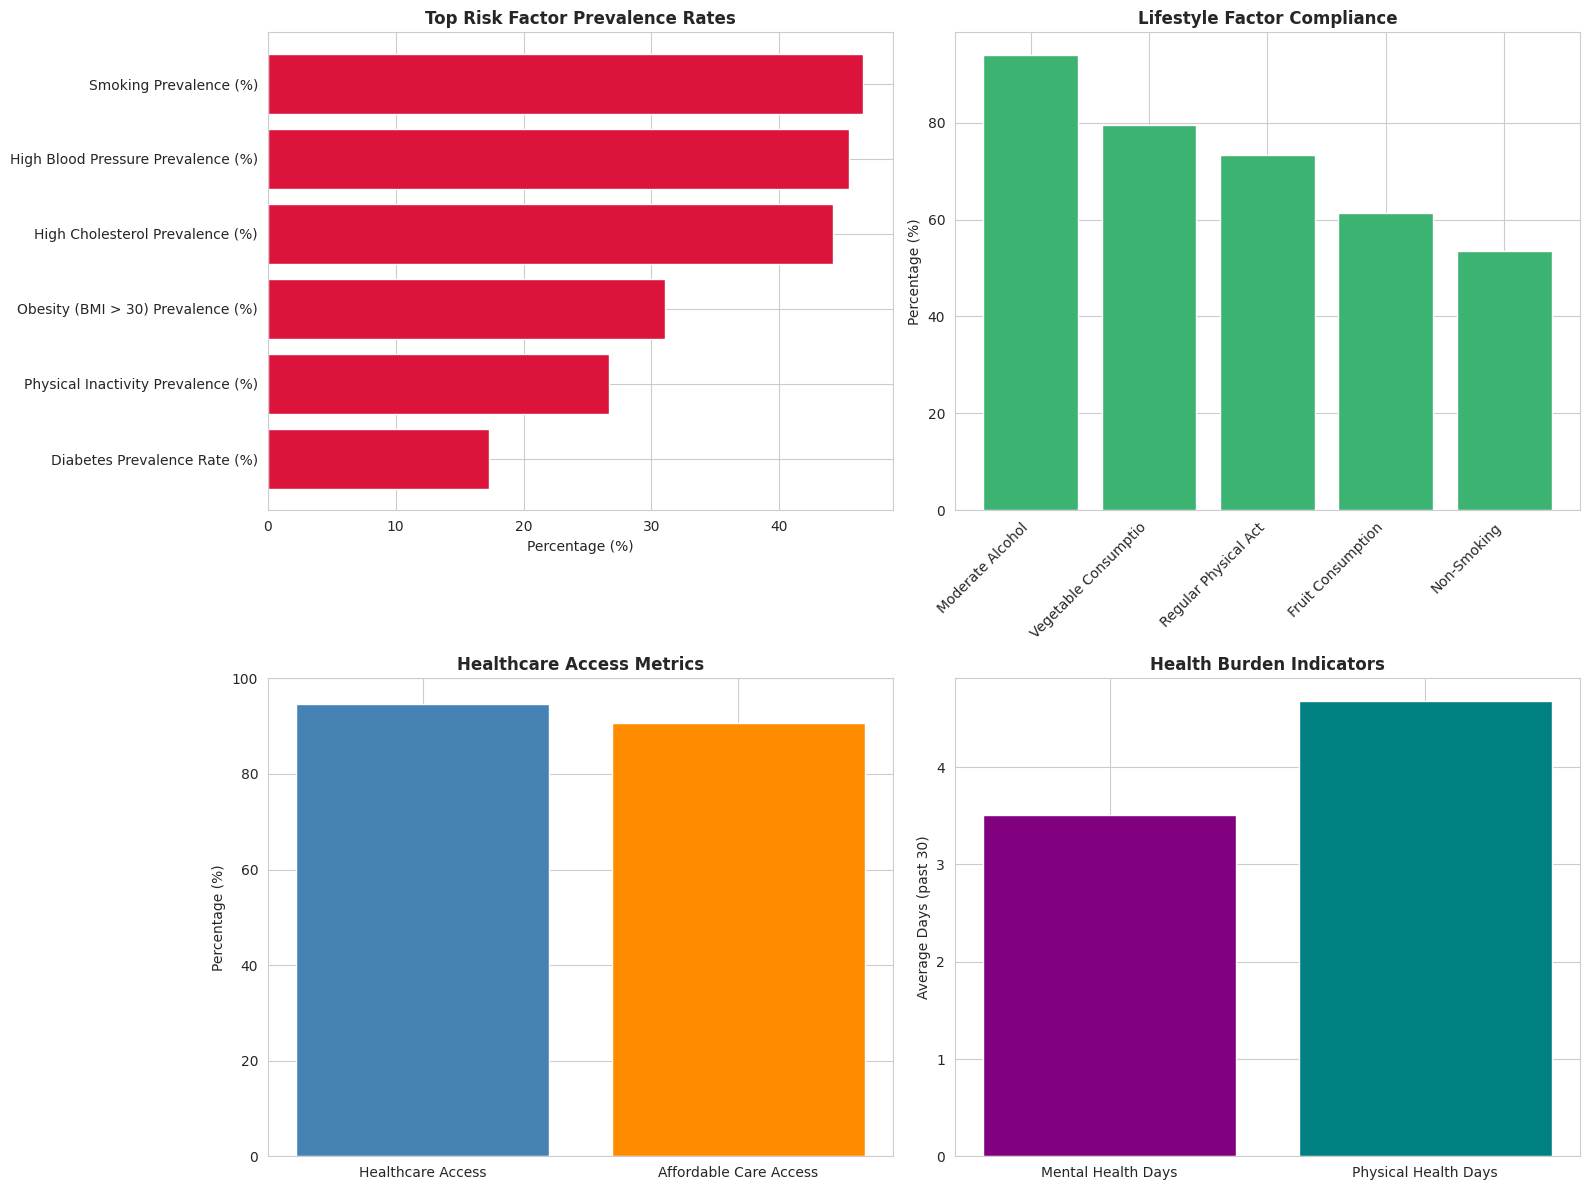

In [5]:
# =============================================================================
# PART 4: HEALTHCARE KPI CALCULATION
# =============================================================================

print("\n" + "="*80)
print("HEALTHCARE KEY PERFORMANCE INDICATORS (KPIs)")
print("="*80)

# Create a KPI results dictionary
kpis = {}

# 4.1 Diabetes Prevalence Rate
if 'Diabetes_012' in df_clean.columns:
    total_patients = len(df_clean)
    diabetes_patients = (df_clean['Diabetes_012'] > 0).sum()
    prevalence_rate = (diabetes_patients / total_patients) * 100
    
    kpis['Diabetes Prevalence Rate (%)'] = round(prevalence_rate, 2)
    print(f"\n--- Diabetes Prevalence Rate ---")
    print(f"Total Patients: {total_patients:,}")
    print(f"Diabetes/Pre-diabetes Patients: {diabetes_patients:,}")
    print(f"Prevalence Rate: {prevalence_rate:.2f}%")

# 4.2 Risk Factor Prevalence
risk_factors = {
    'High Blood Pressure': 'HighBP',
    'High Cholesterol': 'HighChol',
    'Smoking': 'Smoker',
    'Obesity (BMI > 30)': 'BMI',
    'Physical Inactivity': 'PhysActivity',
    'Heart Disease': 'HeartDiseaseorAttack'
}

print("\n--- Risk Factor Prevalence Rates ---")
for risk_name, col in risk_factors.items():
    if col in df_clean.columns:
        if col == 'BMI':
            prevalence = ((df_clean[col] > 30).sum() / len(df_clean)) * 100
        elif col == 'PhysActivity':
            prevalence = ((df_clean[col] == 0).sum() / len(df_clean)) * 100
        else:
            prevalence = (df_clean[col].sum() / len(df_clean)) * 100
        
        kpis[f'{risk_name} Prevalence (%)'] = round(prevalence, 2)
        print(f"{risk_name}: {prevalence:.2f}%")

# 4.3 Healthcare Access Metrics
if 'AnyHealthcare' in df_clean.columns:
    healthcare_access = (df_clean['AnyHealthcare'].sum() / len(df_clean)) * 100
    kpis['Healthcare Access Rate (%)'] = round(healthcare_access, 2)
    print(f"\n--- Healthcare Access Rate: {healthcare_access:.2f}% ---")

if 'NoDocbcCost' in df_clean.columns:
    cost_barrier = (df_clean['NoDocbcCost'].sum() / len(df_clean)) * 100
    kpis['Cost Barrier Rate (%)'] = round(cost_barrier, 2)
    print(f"Cost Barrier to Care: {cost_barrier:.2f}%")

# 4.4 General Health Status Distribution
if 'GenHlth' in df_clean.columns:
    print("\n--- General Health Status Distribution ---")
    health_dist = df_clean['GenHlth'].value_counts(normalize=True).sort_index() * 100
    for category, pct in health_dist.items():
        print(f"Category {category}: {pct:.2f}%")
    
    # Average health score
    avg_health = df_clean['GenHlth'].mean()
    kpis['Average General Health Score'] = round(avg_health, 2)
    print(f"Average Health Score: {avg_health:.2f}")

# 4.5 Mental and Physical Health Burden
if 'MentHlth' in df_clean.columns:
    avg_mental_days = df_clean['MentHlth'].mean()
    mental_burden_pct = (df_clean['MentHlth'] > 0).sum() / len(df_clean) * 100
    kpis['Average Mental Health Days'] = round(avg_mental_days, 2)
    kpis['Population with Mental Health Issues (%)'] = round(mental_burden_pct, 2)
    print(f"\n--- Mental Health Metrics ---")
    print(f"Average days of poor mental health (past 30 days): {avg_mental_days:.2f}")
    print(f"Population affected: {mental_burden_pct:.2f}%")

if 'PhysHlth' in df_clean.columns:
    avg_physical_days = df_clean['PhysHlth'].mean()
    physical_burden_pct = (df_clean['PhysHlth'] > 0).sum() / len(df_clean) * 100
    kpis['Average Physical Health Days'] = round(avg_physical_days, 2)
    kpis['Population with Physical Health Issues (%)'] = round(physical_burden_pct, 2)
    print(f"\n--- Physical Health Metrics ---")
    print(f"Average days of poor physical health (past 30 days): {avg_physical_days:.2f}")
    print(f"Population affected: {physical_burden_pct:.2f}%")

# 4.6 Lifestyle Factors Compliance
lifestyle_factors = {
    'Regular Physical Activity': 'PhysActivity',
    'Fruit Consumption': 'Fruits',
    'Vegetable Consumption': 'Veggies',
    'Non-Smoking': 'Smoker',
    'Moderate Alcohol': 'HvyAlcoholConsump'
}

print("\n--- Lifestyle Factor Compliance Rates ---")
for factor_name, col in lifestyle_factors.items():
    if col in df_clean.columns:
        if col in ['Smoker', 'HvyAlcoholConsump']:
            # For negative factors, calculate non-prevalence
            compliance = ((df_clean[col] == 0).sum() / len(df_clean)) * 100
        else:
            compliance = (df_clean[col].sum() / len(df_clean)) * 100
        
        kpis[f'{factor_name} Rate (%)'] = round(compliance, 2)
        print(f"{factor_name}: {compliance:.2f}%")

# 4.7 Create KPI Summary DataFrame
kpi_df = pd.DataFrame(list(kpis.items()), columns=['KPI', 'Value'])
kpi_df = kpi_df.sort_values('Value', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("KPI SUMMARY TABLE")
print("="*80)
print(kpi_df.to_string(index=False))

# Visualize Key KPIs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# KPI 1: Top Risk Factors
risk_kpis = kpi_df[kpi_df['KPI'].str.contains('Prevalence')].head(6)
axes[0, 0].barh(risk_kpis['KPI'], risk_kpis['Value'], color='crimson')
axes[0, 0].set_xlabel('Percentage (%)')
axes[0, 0].set_title('Top Risk Factor Prevalence Rates', fontweight='bold', fontsize=12)
axes[0, 0].invert_yaxis()

# KPI 2: Lifestyle Compliance
lifestyle_kpis = kpi_df[kpi_df['KPI'].str.contains('Rate') & 
                        kpi_df['KPI'].str.contains('Activity|Fruit|Vegetable|Smoking|Alcohol')]
if not lifestyle_kpis.empty:
    axes[0, 1].bar(range(len(lifestyle_kpis)), lifestyle_kpis['Value'], 
                   color='mediumseagreen')
    axes[0, 1].set_xticks(range(len(lifestyle_kpis)))
    axes[0, 1].set_xticklabels([kpi.split(' Rate')[0][:20] for kpi in lifestyle_kpis['KPI']], 
                                rotation=45, ha='right')
    axes[0, 1].set_ylabel('Percentage (%)')
    axes[0, 1].set_title('Lifestyle Factor Compliance', fontweight='bold', fontsize=12)

# KPI 3: Healthcare Access
if 'Healthcare Access Rate (%)' in kpis and 'Cost Barrier Rate (%)' in kpis:
    access_data = [kpis['Healthcare Access Rate (%)'], 
                   100 - kpis['Cost Barrier Rate (%)']]
    axes[1, 0].bar(['Healthcare Access', 'Affordable Care Access'], 
                   access_data, color=['steelblue', 'darkorange'])
    axes[1, 0].set_ylabel('Percentage (%)')
    axes[1, 0].set_title('Healthcare Access Metrics', fontweight='bold', fontsize=12)
    axes[1, 0].set_ylim([0, 100])

# KPI 4: Health Burden
if 'Average Mental Health Days' in kpis and 'Average Physical Health Days' in kpis:
    burden_data = [kpis['Average Mental Health Days'], 
                   kpis['Average Physical Health Days']]
    axes[1, 1].bar(['Mental Health Days', 'Physical Health Days'], 
                   burden_data, color=['purple', 'teal'])
    axes[1, 1].set_ylabel('Average Days (past 30)')
    axes[1, 1].set_title('Health Burden Indicators', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("\n" + "="*80)


# statistical analysis


STATISTICAL ANALYSIS

--- Correlation Analysis: Diabetes Predictors ---

Top 10 Correlations with Diabetes:
             Feature  Correlation  P-value Significant
             GenHlth        0.285    0.000         Yes
              HighBP        0.262    0.000         Yes
                 BMI        0.212    0.000         Yes
            DiffWalk        0.211    0.000         Yes
            HighChol        0.203    0.000         Yes
                 Age        0.185    0.000         Yes
HeartDiseaseorAttack        0.171    0.000         Yes
            PhysHlth        0.160    0.000         Yes
              Income       -0.147    0.000         Yes
           Education       -0.108    0.000         Yes


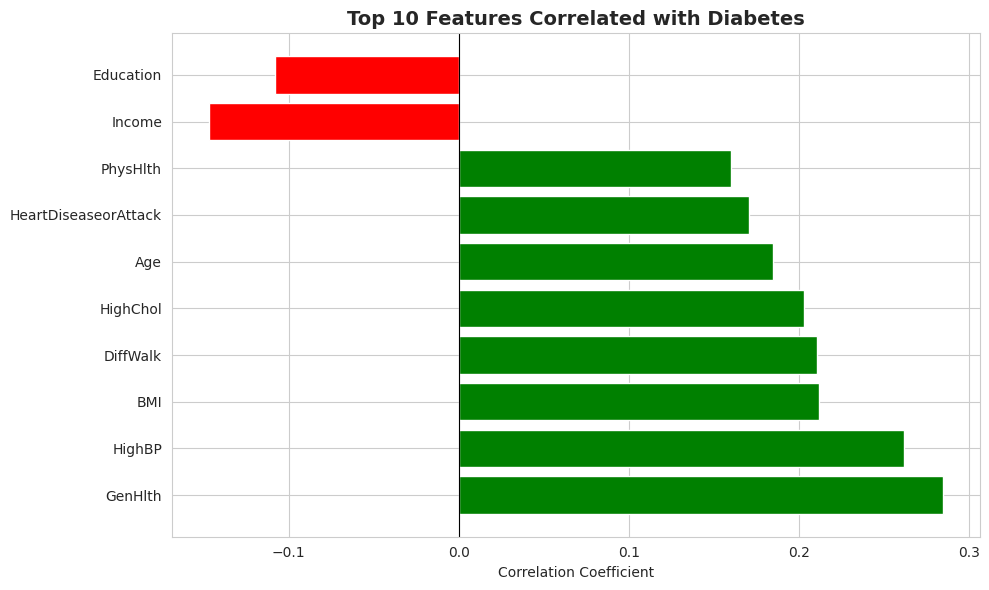


--- Chi-Square Tests: Categorical Variables vs Diabetes ---

Chi-Square Test Results:
             Feature  Chi-Square  P-value  DOF Significant
              HighBP   15825.180    0.000    2         Yes
            DiffWalk   10203.011    0.000    2         Yes
            HighChol    9640.984    0.000    2         Yes
HeartDiseaseorAttack    6708.036    0.000    2         Yes
        PhysActivity    2460.902    0.000    2         Yes
              Stroke    2315.702    0.000    2         Yes
   HvyAlcoholConsump    1036.610    0.000    2         Yes
              Smoker     503.284    0.000    2         Yes
             Veggies     436.456    0.000    2         Yes
                 Sex     244.305    0.000    2         Yes
         NoDocbcCost     179.828    0.000    2         Yes
              Fruits     148.997    0.000    2         Yes
       AnyHealthcare     146.193    0.000    2         Yes

--- ANOVA: Comparing Groups ---

ANOVA: BMI across Diabetes Groups
F-statistic: 5436.1

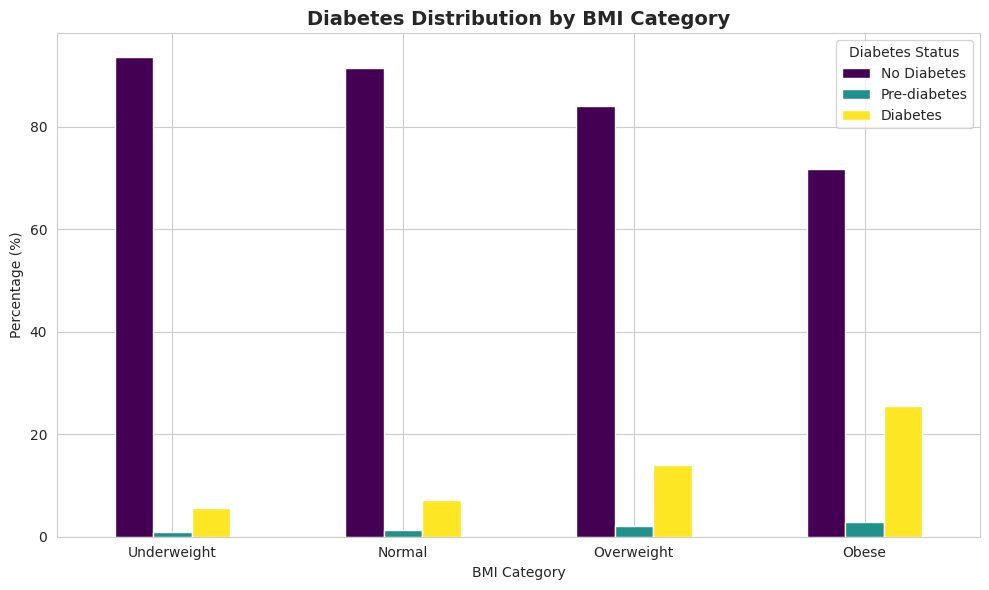


--- Age Group Analysis ---

Diabetes Rate by Age Group (%):
Diabetes_012  0.000  1.000  2.000
Age_Group                        
18-34        96.996  0.650  2.353
35-54        90.749  1.416  7.836
55-69        81.710  2.083 16.207
70+          75.603  2.631 21.766


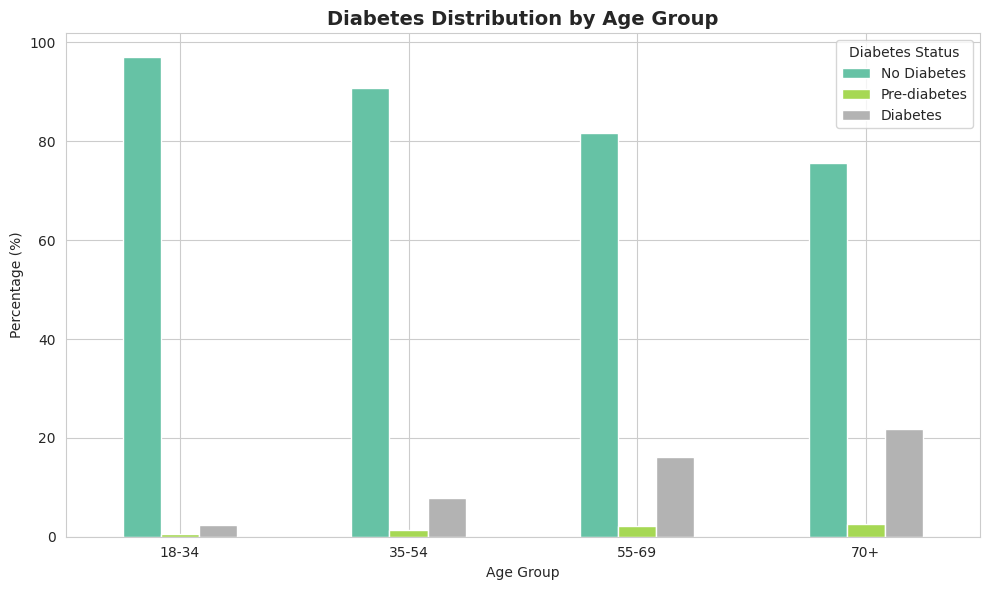


--- Logistic Regression: Diabetes Prediction ---

Logistic Regression Coefficients:
             Feature  Coefficient  Odds_Ratio
              HighBP        0.843       2.323
            HighChol        0.643       1.901
HeartDiseaseorAttack        0.453       1.574
              Stroke        0.363       1.437
        PhysActivity       -0.258       0.772
                 Sex        0.137       1.146
                 Age        0.128       1.137
                 BMI        0.069       1.072
              Smoker        0.049       1.050

Model Performance:
              precision    recall  f1-score   support

 No Diabetes       0.84      0.98      0.91     38012
    Diabetes       0.54      0.11      0.18      7945

    accuracy                           0.83     45957
   macro avg       0.69      0.54      0.54     45957
weighted avg       0.79      0.83      0.78     45957



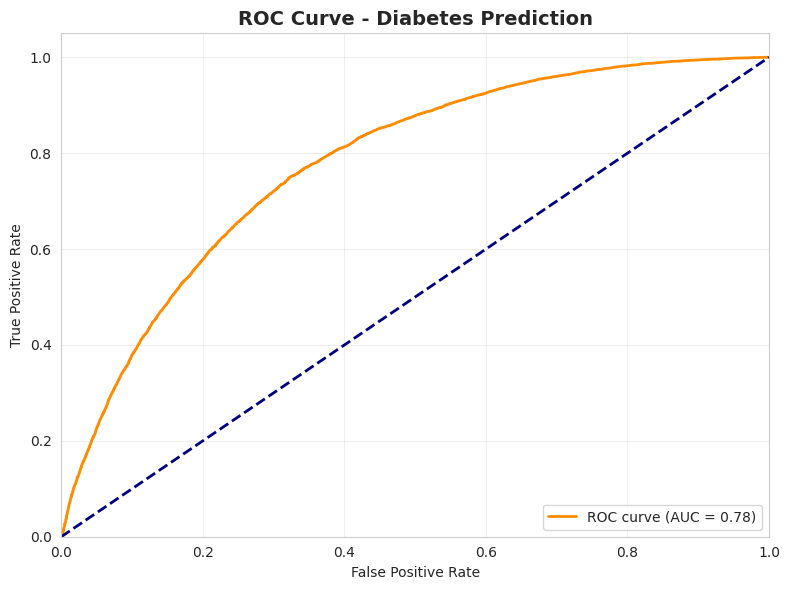

In [6]:
# =============================================================================
# PART 5: STATISTICAL ANALYSIS
# =============================================================================

print("\n" + "="*80)
print("STATISTICAL ANALYSIS")
print("="*80)

# 5.1 Correlation Analysis - Top Predictors of Diabetes
print("\n--- Correlation Analysis: Diabetes Predictors ---")

if 'Diabetes_012' in df_clean.columns:
    numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    numeric_features.remove('Diabetes_012')
    
    correlations = []
    for feature in numeric_features:
        corr, p_value = pearsonr(df_clean[feature], df_clean['Diabetes_012'])
        correlations.append({
            'Feature': feature,
            'Correlation': corr,
            'P-value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })
    
    corr_df = pd.DataFrame(correlations).sort_values('Correlation', 
                                                      ascending=False, 
                                                      key=abs)
    print("\nTop 10 Correlations with Diabetes:")
    print(corr_df.head(10).to_string(index=False))
    
    # Visualize top correlations
    top_corr = corr_df.head(10)
    plt.figure(figsize=(10, 6))
    colors = ['red' if x < 0 else 'green' for x in top_corr['Correlation']]
    plt.barh(top_corr['Feature'], top_corr['Correlation'], color=colors)
    plt.xlabel('Correlation Coefficient')
    plt.title('Top 10 Features Correlated with Diabetes', fontweight='bold', fontsize=14)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.tight_layout()
    plt.show()

# 5.2 Chi-Square Tests for Categorical Variables
print("\n--- Chi-Square Tests: Categorical Variables vs Diabetes ---")

categorical_features = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                        'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 
                        'AnyHealthcare', 'NoDocbcCost', 'Sex', 'DiffWalk']

if 'Diabetes_012' in df_clean.columns:
    chi_results = []
    
    for feature in categorical_features:
        if feature in df_clean.columns:
            # Create contingency table
            contingency = pd.crosstab(df_clean[feature], df_clean['Diabetes_012'])
            chi2, p_value, dof, expected = chi2_contingency(contingency)
            
            chi_results.append({
                'Feature': feature,
                'Chi-Square': chi2,
                'P-value': p_value,
                'DOF': dof,
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
    
    chi_df = pd.DataFrame(chi_results).sort_values('Chi-Square', ascending=False)
    print("\nChi-Square Test Results:")
    print(chi_df.to_string(index=False))

# 5.3 Group Comparisons - ANOVA
print("\n--- ANOVA: Comparing Groups ---")

if 'Diabetes_012' in df_clean.columns and 'BMI' in df_clean.columns:
    # Group BMI by diabetes status
    groups = [df_clean[df_clean['Diabetes_012'] == i]['BMI'].dropna() 
              for i in df_clean['Diabetes_012'].unique()]
    
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nANOVA: BMI across Diabetes Groups")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4e}")
    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    # Group means
    print("\nGroup Means:")
    for i, group_data in enumerate(groups):
        print(f"Group {i}: Mean BMI = {group_data.mean():.2f}, Std = {group_data.std():.2f}")

# 5.4 Normality Tests
print("\n--- Normality Tests (Shapiro-Wilk) ---")

continuous_vars = ['BMI', 'MentHlth', 'PhysHlth']
for var in continuous_vars:
    if var in df_clean.columns:
        # Sample for large datasets (Shapiro-Wilk limitation)
        sample_data = df_clean[var].sample(min(5000, len(df_clean)))
        stat, p_value = stats.shapiro(sample_data)
        print(f"\n{var}:")
        print(f"  Statistic: {stat:.4f}")
        print(f"  P-value: {p_value:.4e}")
        print(f"  Normal distribution: {'Yes' if p_value > 0.05 else 'No'}")

# 5.5 Effect of BMI Categories on Diabetes
if 'BMI_Category' in df_clean.columns and 'Diabetes_012' in df_clean.columns:
    print("\n--- BMI Category Impact on Diabetes ---")
    
    bmi_diabetes = pd.crosstab(df_clean['BMI_Category'], 
                                df_clean['Diabetes_012'], 
                                normalize='index') * 100
    print("\nDiabetes Rate by BMI Category (%):")
    print(bmi_diabetes)
    
    # Visualize
    bmi_diabetes.plot(kind='bar', stacked=False, figsize=(10, 6), 
                      colormap='viridis')
    plt.title('Diabetes Distribution by BMI Category', fontweight='bold', fontsize=14)
    plt.xlabel('BMI Category')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Pre-diabetes', 'Diabetes'])
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 5.6 Age Group Analysis
if 'Age' in df_clean.columns and 'Diabetes_012' in df_clean.columns:
    print("\n--- Age Group Analysis ---")
    
    # Create age groups
    df_clean['Age_Group'] = pd.cut(df_clean['Age'], 
                                     bins=[0, 3, 6, 9, 13],
                                     labels=['18-34', '35-54', '55-69', '70+'])
    
    age_diabetes = pd.crosstab(df_clean['Age_Group'], 
                                df_clean['Diabetes_012'], 
                                normalize='index') * 100
    print("\nDiabetes Rate by Age Group (%):")
    print(age_diabetes)
    
    # Visualize
    age_diabetes.plot(kind='bar', figsize=(10, 6), colormap='Set2')
    plt.title('Diabetes Distribution by Age Group', fontweight='bold', fontsize=14)
    plt.xlabel('Age Group')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Pre-diabetes', 'Diabetes'])
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 5.7 Logistic Regression - Key Predictors
print("\n--- Logistic Regression: Diabetes Prediction ---")

if 'Diabetes_012' in df_clean.columns:
    # Prepare data
    # Convert to binary classification (diabetes vs no diabetes)
    df_clean['Diabetes_Binary'] = (df_clean['Diabetes_012'] > 0).astype(int)
    
    # Select features
    feature_cols = ['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 
                    'HeartDiseaseorAttack', 'PhysActivity', 'Age', 'Sex']
    available_features = [col for col in feature_cols if col in df_clean.columns]
    
    X = df_clean[available_features]
    y = df_clean['Diabetes_Binary']
    
    # Train model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                          random_state=42, 
                                                          stratify=y)
    
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Get coefficients
    coef_df = pd.DataFrame({
        'Feature': available_features,
        'Coefficient': model.coef_[0],
        'Odds_Ratio': np.exp(model.coef_[0])
    }).sort_values('Coefficient', ascending=False, key=abs)
    
    print("\nLogistic Regression Coefficients:")
    print(coef_df.to_string(index=False))
    
    # Model performance
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print("\nModel Performance:")
    print(classification_report(y_test, y_pred, 
                                target_names=['No Diabetes', 'Diabetes']))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Diabetes Prediction', fontweight='bold', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)


# advanced vizualizations


ADVANCED VISUALIZATIONS

--- Creating Risk Profile Visualization ---


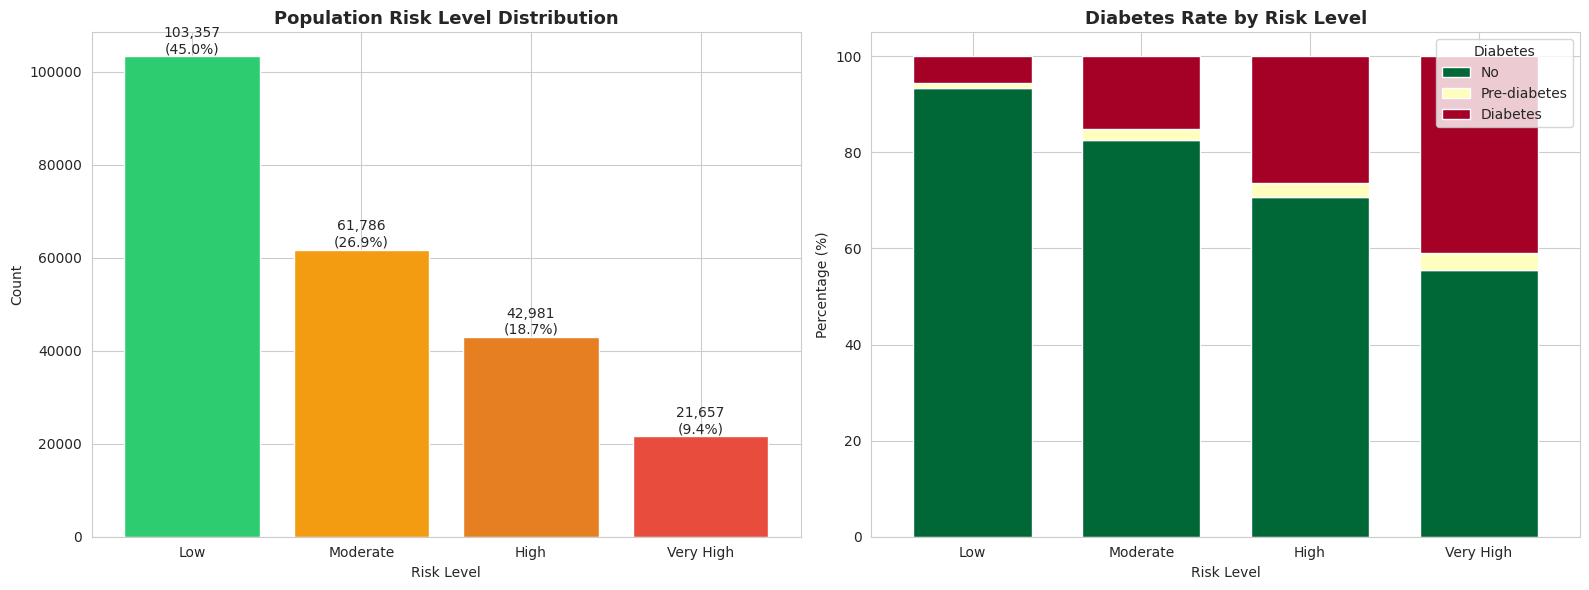


--- Demographic Analysis ---



--- Lifestyle Factors Impact ---


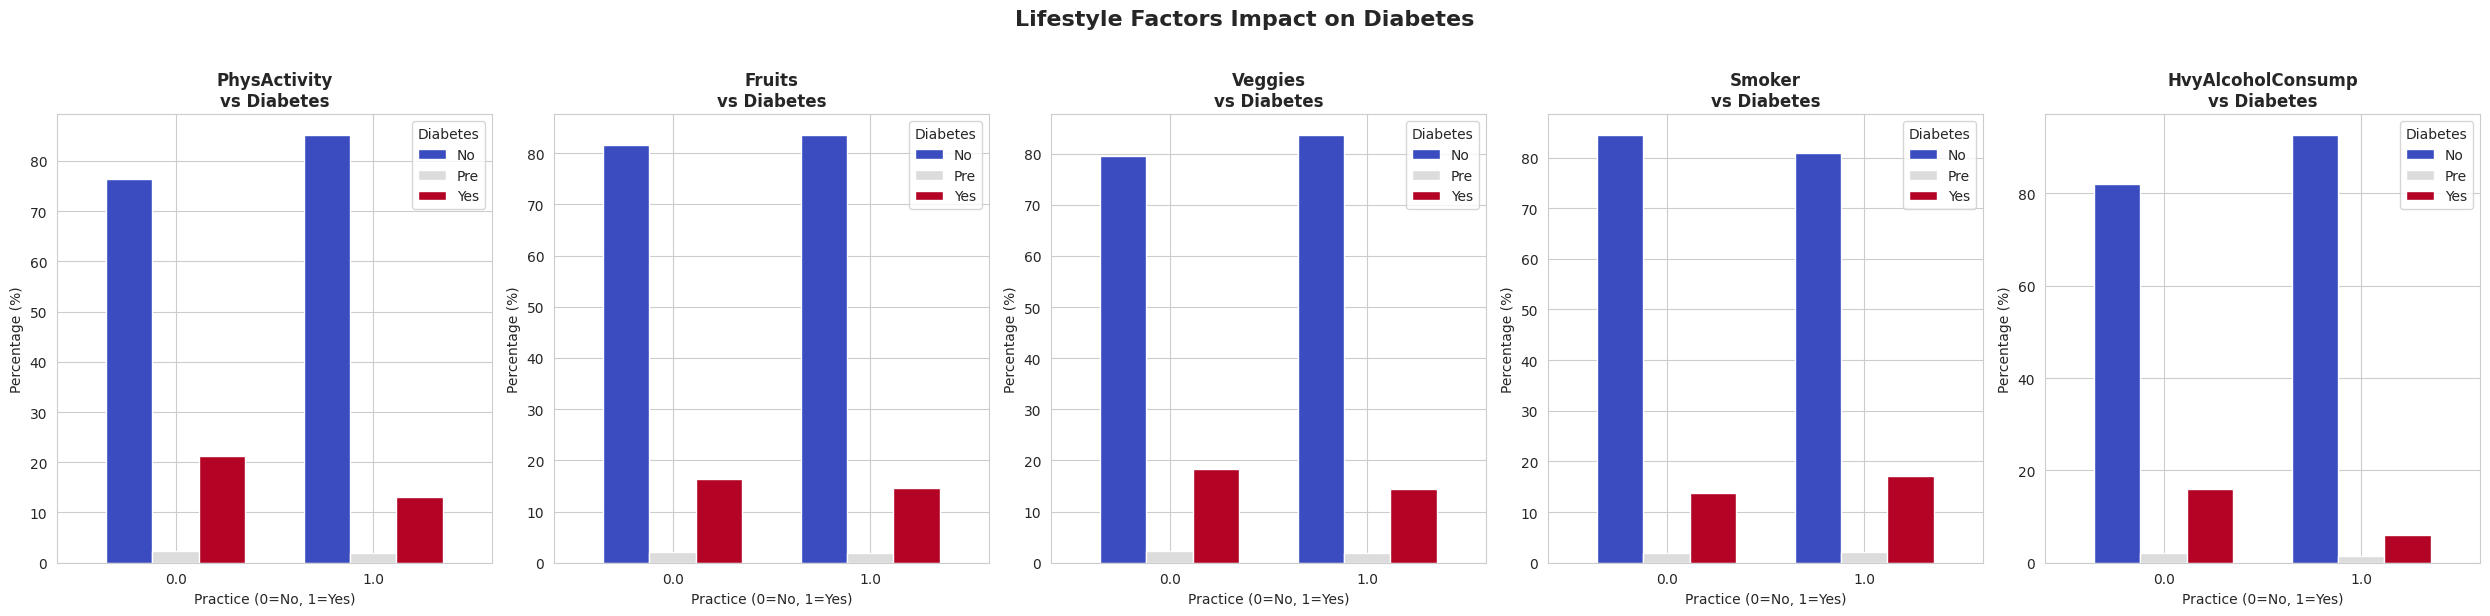


--- Healthcare Access Impact ---


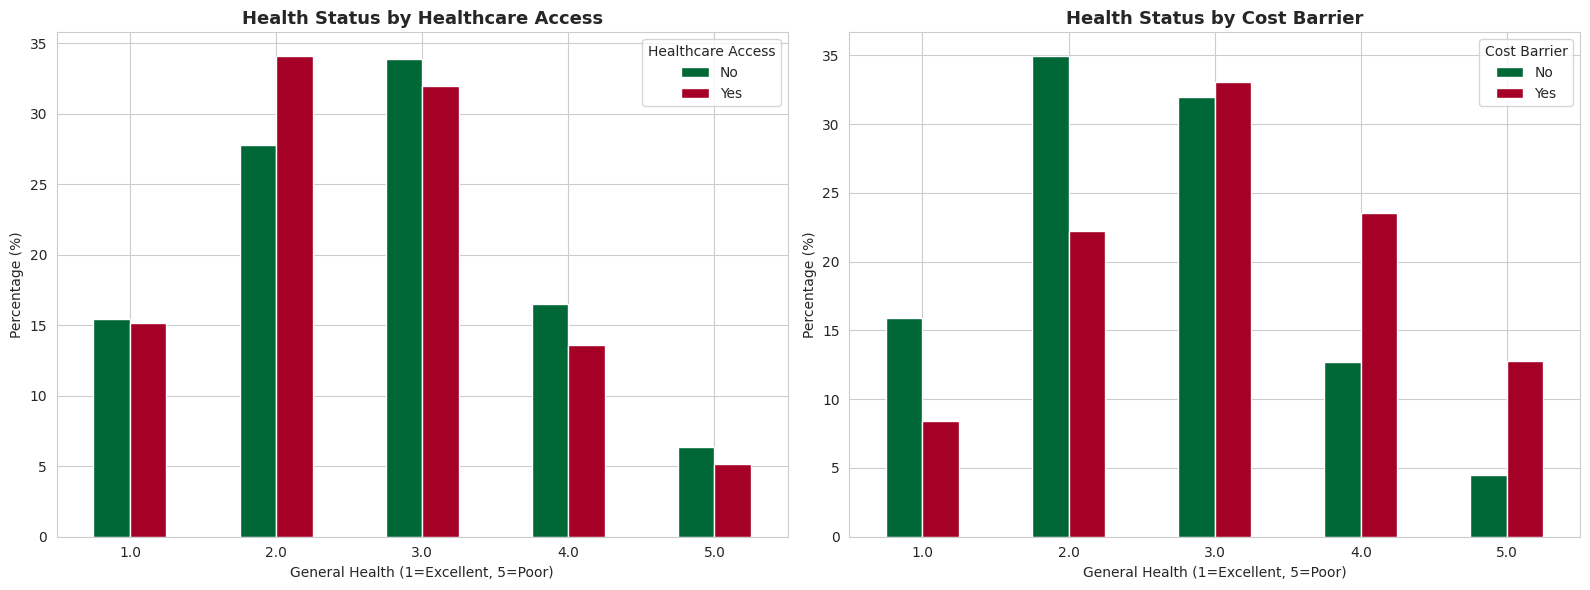

In [7]:
# =============================================================================
# PART 6: ADVANCED VISUALIZATIONS AND INSIGHTS
# =============================================================================

print("\n" + "="*80)
print("ADVANCED VISUALIZATIONS")
print("="*80)

# 6.1 Multi-factor Risk Profile
print("\n--- Creating Risk Profile Visualization ---")

if all(col in df_clean.columns for col in ['HighBP', 'HighChol', 'BMI', 'Smoker']):
    # Create risk score
    df_clean['Risk_Score'] = 0
    df_clean['Risk_Score'] += df_clean['HighBP']
    df_clean['Risk_Score'] += df_clean['HighChol']
    df_clean['Risk_Score'] += (df_clean['BMI'] > 30).astype(int)
    df_clean['Risk_Score'] += df_clean['Smoker']
    
    if 'HeartDiseaseorAttack' in df_clean.columns:
        df_clean['Risk_Score'] += df_clean['HeartDiseaseorAttack']
    
    # Categorize risk
    df_clean['Risk_Level'] = pd.cut(df_clean['Risk_Score'], 
                                      bins=[-1, 1, 2, 3, 10],
                                      labels=['Low', 'Moderate', 'High', 'Very High'])
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Risk distribution
    risk_counts = df_clean['Risk_Level'].value_counts().sort_index()
    colors_risk = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
    axes[0].bar(risk_counts.index, risk_counts.values, color=colors_risk)
    axes[0].set_title('Population Risk Level Distribution', fontweight='bold', fontsize=13)
    axes[0].set_xlabel('Risk Level')
    axes[0].set_ylabel('Count')
    
    for i, v in enumerate(risk_counts.values):
        axes[0].text(i, v, f'{v:,}\n({v/len(df_clean)*100:.1f}%)', 
                    ha='center', va='bottom')
    
    # Risk vs Diabetes
    if 'Diabetes_012' in df_clean.columns:
        risk_diabetes = pd.crosstab(df_clean['Risk_Level'], 
                                     df_clean['Diabetes_012'], 
                                     normalize='index') * 100
        risk_diabetes.plot(kind='bar', stacked=True, ax=axes[1], 
                          colormap='RdYlGn_r', width=0.7)
        axes[1].set_title('Diabetes Rate by Risk Level', fontweight='bold', fontsize=13)
        axes[1].set_xlabel('Risk Level')
        axes[1].set_ylabel('Percentage (%)')
        axes[1].legend(title='Diabetes', labels=['No', 'Pre-diabetes', 'Diabetes'])
        axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()

# 6.2 Demographic Analysis Dashboard
print("\n--- Demographic Analysis ---")

if all(col in df_clean.columns for col in ['Age', 'Sex', 'Income', 'Education']):
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Age Distribution', 'Gender Distribution',
                       'Income Level Distribution', 'Education Level Distribution'),
        specs=[[{'type': 'histogram'}, {'type': 'pie'}],
               [{'type': 'bar'}, {'type': 'bar'}]]
    )
    
    # Age histogram
    fig.add_trace(
        go.Histogram(x=df_clean['Age'], name='Age', marker_color='steelblue'),
        row=1, col=1
    )
    
    # Gender pie
    if 'Sex_Label' in df_labeled.columns:
        gender_counts = df_labeled['Sex_Label'].value_counts()
        fig.add_trace(
            go.Pie(labels=gender_counts.index, values=gender_counts.values, 
                   name='Gender'),
            row=1, col=2
        )
    
    # Income distribution
    income_counts = df_clean['Income'].value_counts().sort_index()
    fig.add_trace(
        go.Bar(x=income_counts.index, y=income_counts.values, 
               name='Income', marker_color='mediumseagreen'),
        row=2, col=1
    )
    
    # Education distribution
    edu_counts = df_clean['Education'].value_counts().sort_index()
    fig.add_trace(
        go.Bar(x=edu_counts.index, y=edu_counts.values, 
               name='Education', marker_color='coral'),
        row=2, col=2
    )
    
    fig.update_layout(height=800, showlegend=False, 
                     title_text="Demographic Analysis Dashboard",
                     title_font_size=18)
    fig.show()

# 6.3 Lifestyle Factors Comparison
print("\n--- Lifestyle Factors Impact ---")

lifestyle_cols = ['PhysActivity', 'Fruits', 'Veggies', 'Smoker', 'HvyAlcoholConsump']
available_lifestyle = [col for col in lifestyle_cols if col in df_clean.columns]

if available_lifestyle and 'Diabetes_012' in df_clean.columns:
    fig, axes = plt.subplots(1, len(available_lifestyle), 
                             figsize=(5*len(available_lifestyle), 6))
    
    if len(available_lifestyle) == 1:
        axes = [axes]
    
    for idx, factor in enumerate(available_lifestyle):
        lifestyle_diabetes = pd.crosstab(df_clean[factor], 
                                          df_clean['Diabetes_012'], 
                                          normalize='index') * 100
        
        lifestyle_diabetes.plot(kind='bar', ax=axes[idx], 
                               colormap='coolwarm', width=0.7)
        axes[idx].set_title(f'{factor}\nvs Diabetes', fontweight='bold')
        axes[idx].set_xlabel('Practice (0=No, 1=Yes)')
        axes[idx].set_ylabel('Percentage (%)')
        axes[idx].legend(title='Diabetes', labels=['No', 'Pre', 'Yes'])
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=0)
    
    plt.suptitle('Lifestyle Factors Impact on Diabetes', 
                fontweight='bold', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# 6.4 Healthcare Access vs Outcomes
print("\n--- Healthcare Access Impact ---")

if all(col in df_clean.columns for col in ['AnyHealthcare', 'NoDocbcCost', 'GenHlth']):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Healthcare access vs health status
    health_access = pd.crosstab(df_clean['AnyHealthcare'], 
                                 df_clean['GenHlth'], 
                                 normalize='index') * 100
    
    health_access.T.plot(kind='bar', ax=axes[0], colormap='RdYlGn_r')
    axes[0].set_title('Health Status by Healthcare Access', fontweight='bold', fontsize=13)
    axes[0].set_xlabel('General Health (1=Excellent, 5=Poor)')
    axes[0].set_ylabel('Percentage (%)')
    axes[0].legend(title='Healthcare Access', labels=['No', 'Yes'])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
    
    # Cost barrier impact
    cost_health = pd.crosstab(df_clean['NoDocbcCost'], 
                              df_clean['GenHlth'], 
                              normalize='index') * 100
    
    cost_health.T.plot(kind='bar', ax=axes[1], colormap='RdYlGn_r')
    axes[1].set_title('Health Status by Cost Barrier', fontweight='bold', fontsize=13)
    axes[1].set_xlabel('General Health (1=Excellent, 5=Poor)')
    axes[1].set_ylabel('Percentage (%)')
    axes[1].legend(title='Cost Barrier', labels=['No', 'Yes'])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)


# insights & recommendations

In [8]:
# =============================================================================
# PART 7: KEY INSIGHTS AND RECOMMENDATIONS
# =============================================================================

print("\n" + "="*80)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("="*80)

insights = []
recommendations = []

# Insight 1: BMI Impact
if 'BMI_Category' in df_clean.columns and 'Diabetes_012' in df_clean.columns:
    obese_diabetes_rate = (df_clean[df_clean['BMI_Category'] == 'Obese']['Diabetes_012'] > 0).sum() / \
                          len(df_clean[df_clean['BMI_Category'] == 'Obese']) * 100
    normal_diabetes_rate = (df_clean[df_clean['BMI_Category'] == 'Normal']['Diabetes_012'] > 0).sum() / \
                           len(df_clean[df_clean['BMI_Category'] == 'Normal']) * 100
    
    if obese_diabetes_rate > normal_diabetes_rate:
        insights.append(f"Obese individuals have {obese_diabetes_rate:.1f}% diabetes rate compared to "
                       f"{normal_diabetes_rate:.1f}% in normal weight individuals - "
                       f"{(obese_diabetes_rate/normal_diabetes_rate - 1)*100:.0f}% higher risk")
        recommendations.append("Implement targeted weight management programs for individuals with BMI > 30")

# Insight 2: Age Factor
if 'Age_Group' in df_clean.columns and 'Diabetes_012' in df_clean.columns:
    age_diabetes = df_clean.groupby('Age_Group')['Diabetes_Binary'].mean() * 100
    oldest_group = age_diabetes.idxmax()
    highest_rate = age_diabetes.max()
    
    insights.append(f"Age group {oldest_group} has the highest diabetes prevalence at {highest_rate:.1f}%")
    recommendations.append("Prioritize screening and preventive care programs for elderly population (65+)")

# Insight 3: High Blood Pressure
if 'HighBP' in df_clean.columns and 'Diabetes_012' in df_clean.columns:
    hbp_diabetes = (df_clean[df_clean['HighBP'] == 1]['Diabetes_012'] > 0).sum() / \
                   len(df_clean[df_clean['HighBP'] == 1]) * 100
    no_hbp_diabetes = (df_clean[df_clean['HighBP'] == 0]['Diabetes_012'] > 0).sum() / \
                      len(df_clean[df_clean['HighBP'] == 0]) * 100
    
    insights.append(f"Individuals with high BP have {hbp_diabetes:.1f}% diabetes rate vs "
                   f"{no_hbp_diabetes:.1f}% without - strong correlation detected")
    recommendations.append("Integrate hypertension management with diabetes prevention programs")

# Insight 4: Physical Activity
if 'PhysActivity' in df_clean.columns:
    inactive_rate = (df_clean['PhysActivity'] == 0).sum() / len(df_clean) * 100
    
    if inactive_rate > 30:
        insights.append(f"{inactive_rate:.1f}% of population reports no physical activity")
        recommendations.append("Launch community-based physical activity initiatives and awareness campaigns")

# Insight 5: Healthcare Access
if 'NoDocbcCost' in df_clean.columns:
    cost_barrier_rate = (df_clean['NoDocbcCost'].sum() / len(df_clean)) * 100
    
    if cost_barrier_rate > 10:
        insights.append(f"{cost_barrier_rate:.1f}% of population cannot afford healthcare")
        recommendations.append("Expand subsidized healthcare programs and insurance coverage for low-income groups")

# Insight 6: Mental Health Burden
if 'MentHlth' in df_clean.columns:
    avg_mental_days = df_clean['MentHlth'].mean()
    mental_affected = (df_clean['MentHlth'] > 14).sum() / len(df_clean) * 100
    
    insights.append(f"Average {avg_mental_days:.1f} days of poor mental health per month; "
                   f"{mental_affected:.1f}% report significant mental health issues")
    recommendations.append("Integrate mental health services with primary care and diabetes management programs")

# Insight 7: Multiple Risk Factors
if 'Risk_Level' in df_clean.columns:
    high_risk = ((df_clean['Risk_Level'] == 'High') | 
                 (df_clean['Risk_Level'] == 'Very High')).sum() / len(df_clean) * 100
    
    insights.append(f"{high_risk:.1f}% of population classified as high/very high risk")
    recommendations.append("Establish multidisciplinary care teams for high-risk patients with personalized intervention plans")

# Insight 8: Smoking Impact
if 'Smoker' in df_clean.columns and 'Diabetes_012' in df_clean.columns:
    smoker_diabetes = (df_clean[df_clean['Smoker'] == 1]['Diabetes_012'] > 0).sum() / \
                      len(df_clean[df_clean['Smoker'] == 1]) * 100
    
    insights.append(f"Smoking prevalence correlates with {smoker_diabetes:.1f}% diabetes rate among smokers")
    recommendations.append("Implement comprehensive smoking cessation programs linked to diabetes prevention")

# Display Insights
print("\n🔍 KEY INSIGHTS:\n")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}\n")

print("\n" + "="*80)
print("💡 RECOMMENDATIONS:\n")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}\n")

# Create Summary Report
summary_report = {
    'Total Patients Analyzed': len(df_clean),
    'Diabetes Prevalence': f"{kpis.get('Diabetes Prevalence Rate (%)', 'N/A')}%",
    'High-Risk Population': f"{high_risk if 'high_risk' in locals() else 'N/A'}%",
    'Healthcare Access Rate': f"{kpis.get('Healthcare Access Rate (%)', 'N/A')}%",
    'Physical Inactivity Rate': f"{kpis.get('Physical Inactivity Prevalence (%)', 'N/A')}%",
    'Average BMI': f"{df_clean['BMI'].mean():.2f}" if 'BMI' in df_clean.columns else 'N/A'
}

print("\n" + "="*80)
print("📊 EXECUTIVE SUMMARY")
print("="*80)
for key, value in summary_report.items():
    print(f"{key:.<40} {value:>20}")

print("\n" + "="*80)
print("PROJECT ANALYSIS COMPLETE")
print("="*80)



KEY INSIGHTS AND RECOMMENDATIONS

🔍 KEY INSIGHTS:

1. Obese individuals have 28.3% diabetes rate compared to 8.5% in normal weight individuals - 232% higher risk

2. Age group 70+ has the highest diabetes prevalence at 24.4%

3. Individuals with high BP have 28.1% diabetes rate vs 8.3% without - strong correlation detected

4. Average 3.5 days of poor mental health per month; 10.2% report significant mental health issues

5. 28.1% of population classified as high/very high risk

6. Smoking prevalence correlates with 19.2% diabetes rate among smokers


💡 RECOMMENDATIONS:

1. Implement targeted weight management programs for individuals with BMI > 30

2. Prioritize screening and preventive care programs for elderly population (65+)

3. Integrate hypertension management with diabetes prevention programs

4. Integrate mental health services with primary care and diabetes management programs

5. Establish multidisciplinary care teams for high-risk patients with personalized intervention pl